In [1]:
import numpy as np
import pandas as pd

# Visualization modules
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Helpers
import helpers
import wrangle
import model
import viz

## Best features

In [2]:
target = 'quality'
feats = [
    'alcohol',
    'volatile_acidity',
    'citric_acid',
    'residual_sugar',
    'total_sulfur_dioxide',
    'hydronium',
    'density',
    'ions',
    ]

---
# Modeling code

In [3]:
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error

@TODO
- wrangle and split
- scale and polynomial
- baseline mean
- polynomial regression
- linear regression
- knn regression
- random forest regressor


In [4]:
feats + [target]

['alcohol',
 'volatile_acidity',
 'citric_acid',
 'residual_sugar',
 'total_sulfur_dioxide',
 'hydronium',
 'density',
 'ions',
 'quality']

In [5]:
red = wrangle.wrangle_data("red")
white = wrangle.wrangle_data("white")
red = model.drop_outliers(red, "red", method='manual')
white = model.drop_outliers(white, "white", method='manual')
red = model.add_features(red)
white = model.add_features(white)
red = red[feats + [target]]
white = white[feats + [target]]
red_train, red_validate, red_test = wrangle.train_test_validate_split(red)
white_train, white_validate, white_test = wrangle.train_test_validate_split(white)


In [6]:
r_xt = red_train[feats]
r_xv = red_validate[feats]
r_xs = red_test[feats]
r_yt = red_train[target]
r_yv = red_validate[target]
r_ys = red_test[target]

In [7]:
red_scaler = helpers.prep.train_scaler(r_xt)
r_xt = red_scaler.transform(r_xt)
r_xv = red_scaler.transform(r_xv)
r_xs = red_scaler.transform(r_xs)

In [8]:

red_poly = PolynomialFeatures(2)
red_poly.fit(r_xt)
r_xt_poly = red_poly.transform(r_xt)
r_xv_poly = red_poly.transform(r_xv)
r_xs_poly = red_poly.transform(r_xs)


In [9]:
w_xt = white_train[feats]
w_xv = white_validate[feats]
w_xs = white_test[feats]
w_yt = white_train[target]
w_yv = white_validate[target]
w_ys = white_test[target]

In [10]:
white_scaler = helpers.prep.train_scaler(w_xt)
w_xt = white_scaler.transform(w_xt)
w_xv = white_scaler.transform(w_xv)
w_xs = white_scaler.transform(w_xs)

In [11]:
white_poly = PolynomialFeatures(3)
white_poly.fit(w_xt)
w_xt_poly = white_poly.transform(w_xt)
w_xv_poly = white_poly.transform(w_xv)
w_xs_poly = white_poly.transform(w_xs)

In [12]:
red_models = {
    'Mode Baseline': helpers.eval.BaselineModel(method='mode'),
    'Linear Regression': LinearRegression(positive=True),
    # 'Random Forest': RandomForestRegressor(max_depth=10),
    'KNN Regression': KNeighborsRegressor(n_neighbors=5),
}
red_poly_models = {
    'Linear Regression': LinearRegression(positive=True),
    # 'Random Forest': RandomForestRegressor(max_depth=10),
    'KNN Regression': KNeighborsRegressor(n_neighbors=5),
}


In [13]:
for name, model in red_models.items():
    model.fit(r_xt, r_yt)
for name, model in red_poly_models.items():
    model.fit(r_xt_poly, r_yt)

In [14]:
scores = {}
for name, model in red_models.items():
    tp = model.predict(r_xt)
    vp = model.predict(r_xv)
    scores[f'{name}'] = {
        'type' : 'red',
        'train_rmse' : mean_squared_error(r_yt, tp, squared=False),
        'validate_rmse' : mean_squared_error(r_yv, vp, squared=False),
        'tp': tp,
        'vp': vp
    }

for name, model in red_poly_models.items():
    tp = model.predict(r_xt_poly)
    vp = model.predict(r_xv_poly)
    scores[f'{name} (Polynomial)'] = {
        'type' : 'red',
        'train_rmse' : mean_squared_error(r_yt, tp, squared=False),
        'validate_rmse' : mean_squared_error(r_yv, vp, squared=False),
        'tp': tp,
        'vp': vp
    }

In [15]:
scores_df = pd.DataFrame.from_dict(scores, orient='index')

In [16]:
white_models = {
    'Mode Baseline': helpers.eval.BaselineModel(method='mode'),
    'Linear Regression': LinearRegression(positive=True),
    # 'Random Forest': RandomForestRegressor(max_depth=10),
    'KNN Regression': KNeighborsRegressor(n_neighbors=5),
}
white_poly_models = {
    'Linear Regression': LinearRegression(positive=True),
    # 'Random Forest': RandomForestRegressor(max_depth=10),
    'KNN Regression': KNeighborsRegressor(n_neighbors=5),
}
for name, model in white_models.items():
    model.fit(w_xt, w_yt)
for name, model in white_poly_models.items():
    model.fit(w_xt_poly, w_yt)

In [17]:
for name, model in white_models.items():
    tp = model.predict(w_xt)
    vp = model.predict(w_xv)
    scores[f'{name}'] = {
        'type' : 'white',
        'train_rmse' : mean_squared_error(w_yt, tp, squared=False),
        'validate_rmse' : mean_squared_error(w_yv, vp, squared=False),
        'tp': tp,
        'vp': vp
    }

for name, model in white_poly_models.items():
    tp = model.predict(w_xt_poly)
    vp = model.predict(w_xv_poly)
    scores[f'{name} (Polynomial)'] = {
        'type' : 'white',
        'train_rmse' : mean_squared_error(w_yt, tp, squared=False),
        'validate_rmse' : mean_squared_error(w_yv, vp, squared=False),
        'tp': tp,
        'vp': vp
    }

In [18]:
temp = pd.DataFrame.from_dict(scores, orient='index')
scores_df = pd.concat([scores_df, temp])

In [19]:
scores_df.sort_values('validate_rmse', ascending=True)

,type,train_rmse,validate_rmse,tp,vp
Linear Regression,red,0.704421,0.645115,"[5.2703544644544, 5.369022677571477, 5.3340935...","[5.293355617351765, 5.049093523644327, 5.11689..."
Linear Regression (Polynomial),red,0.700308,0.647785,"[5.152842450763995, 5.352626408276908, 5.27367...","[5.306591516641859, 5.1005245233626475, 5.1577..."
KNN Regression,red,0.582870,0.667938,"[5.2, 5.2, 5.0, 5.6, 5.6, 4.6, 5.0, 5.0, 5.2, ...","[4.8, 5.6, 4.8, 6.2, 5.0, 5.2, 5.2, 5.2, 5.2, ..."
KNN Regression (Polynomial),red,0.577259,0.679393,"[5.2, 5.2, 5.0, 5.6, 5.6, 4.8, 5.0, 5.0, 5.2, ...","[4.8, 5.6, 4.8, 6.2, 5.0, 5.2, 5.2, 5.2, 5.0, ..."
Linear Regression (Polynomial),white,0.794472,0.774673,"[5.663149503331878, 5.533480994506018, 5.72028...","[5.638098199931875, 5.831391119965524, 6.35778..."
Linear Regression,white,0.797802,0.777457,"[5.673564144308267, 5.540563979782368, 5.74560...","[5.636789555215734, 5.867541511793935, 6.38561..."
KNN Regression,white,0.656197,0.785524,"[5.6, 5.8, 6.4, 7.0, 7.0, 6.4, 4.8, 6.2, 6.4, ...","[5.6, 6.4, 6.2, 5.2, 5.4, 5.6, 6.0, 5.0, 5.8, ..."
KNN Regression (Polynomial),white,0.653444,0.787931,"[5.8, 5.8, 6.4, 7.0, 6.2, 6.6, 5.2, 6.2, 6.4, ...","[5.6, 6.4, 6.2, 5.2, 5.2, 5.6, 6.2, 5.4, 5.6, ..."
Mode Baseline,red,0.921456,0.885135,"[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...","[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ..."
Mode Baseline,white,0.902032,0.900325,"[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...","[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ..."


In [20]:
scores_df = scores_df.reset_index().rename(columns={'index': 'model'})
scores_df

,model,type,train_rmse,validate_rmse,tp,vp
0,Mode Baseline,red,0.921456,0.885135,"[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...","[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ..."
1,Linear Regression,red,0.704421,0.645115,"[5.2703544644544, 5.369022677571477, 5.3340935...","[5.293355617351765, 5.049093523644327, 5.11689..."
2,KNN Regression,red,0.582870,0.667938,"[5.2, 5.2, 5.0, 5.6, 5.6, 4.6, 5.0, 5.0, 5.2, ...","[4.8, 5.6, 4.8, 6.2, 5.0, 5.2, 5.2, 5.2, 5.2, ..."
3,Linear Regression (Polynomial),red,0.700308,0.647785,"[5.152842450763995, 5.352626408276908, 5.27367...","[5.306591516641859, 5.1005245233626475, 5.1577..."
4,KNN Regression (Polynomial),red,0.577259,0.679393,"[5.2, 5.2, 5.0, 5.6, 5.6, 4.8, 5.0, 5.0, 5.2, ...","[4.8, 5.6, 4.8, 6.2, 5.0, 5.2, 5.2, 5.2, 5.0, ..."
5,Mode Baseline,white,0.902032,0.900325,"[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...","[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ..."
6,Linear Regression,white,0.797802,0.777457,"[5.673564144308267, 5.540563979782368, 5.74560...","[5.636789555215734, 5.867541511793935, 6.38561..."
7,KNN Regression,white,0.656197,0.785524,"[5.6, 5.8, 6.4, 7.0, 7.0, 6.4, 4.8, 6.2, 6.4, ...","[5.6, 6.4, 6.2, 5.2, 5.4, 5.6, 6.0, 5.0, 5.8, ..."
8,Linear Regression (Polynomial),white,0.794472,0.774673,"[5.663149503331878, 5.533480994506018, 5.72028...","[5.638098199931875, 5.831391119965524, 6.35778..."
9,KNN Regression (Polynomial),white,0.653444,0.787931,"[5.8, 5.8, 6.4, 7.0, 6.2, 6.6, 5.2, 6.2, 6.4, ...","[5.6, 6.4, 6.2, 5.2, 5.2, 5.6, 6.2, 5.4, 5.6, ..."


In [25]:
wine_colors = ['#efdaa3', '#8c0f0a']
alt_white = '#eccd13'
wine_palette = sns.color_palette(wine_colors)
wine_palette_r = sns.color_palette(list(reversed(wine_colors)))
sns.set_palette(wine_palette)

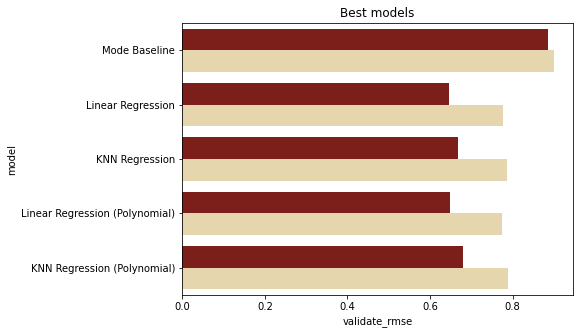

In [38]:
plt.figure(figsize=[7,5])
ax = sns.barplot(data=scores_df, y='model', x='validate_rmse', hue='type', palette=wine_palette_r)
ax.get_legend().remove()
plt.title('Best models')
plt.show()